In [1]:
import os
import sys
from pathlib import Path
import pickle
import copy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Add the parent directory of src/utils to sys.path
sys.path.append(str(Path.cwd().parent / 'src' / 'utils'))

# Now import cmap
df = pd.read_csv("../outputs/wandb_export/wandb_runs.csv")
dataset_metrics = df.columns[df.columns.str.startswith('summary.DR/dataset')]
embedding_metrics = df.columns[df.columns.str.startswith('summary.DR/embedding')]
admixture_metrics = df.columns[df.columns.str.startswith('admixture_preservation')]

cols_to_keep = dataset_metrics.tolist() + embedding_metrics.tolist() + admixture_metrics.tolist()

config_cols = df.columns[df.columns.str.startswith('config.algorithm.dimensionality_reduction')].tolist()
cols_to_keep = cols_to_keep + config_cols

df = df[cols_to_keep]

In [3]:
df = df.rename(columns={'config.algorithm.dimensionality_reduction._target_' : 'method'})

df['method'] = pd.Categorical(df['method']).rename_categories(
    {'src.algorithms.mds.MDSModule': 'MDS',
     'src.algorithms.phate.PHATEModule': 'PHATE',
     'src.algorithms.diffusionmap.DiffusionMapModule': 'Diffusion Maps',
     'src.algorithms.tsne.TSNEModule': 't-SNE', 
     'src.algorithms.umap.UMAPModule': 'UMAP',
     'src.algorithms.umap.PCAModule': 'PCA'})

df['method'] = df['method'].cat.add_categories(["pca (2D)", "pca (50D)"])
df = df.rename(columns={'config.algorithm.dimensionality_reduction.n_components': 'n_components'})

# Treat PCA (2D) different than PCA (50D)
df.loc[((df['n_components']==2) & (df['method'] == 'PCA')), 'method'] = "pca (2D)"
df.loc[((df['n_components']==50) & (df['method'] == 'PCA')), 'method'] = "pca (50D)"

In [4]:
def clean_column_name(col):
    # Define known prefixes to strip
    prefixes = [
        "summary.DR/dataset.",
        "summary.DR/embedding.",
        "admixture_preservation.dataset.",
        "config.algorithm.dimensionality_reduction."
        
    ]

    # Remove prefix if matched
    for prefix in prefixes:
        if col.startswith(prefix):
            col = col[len(prefix):]
            break  # only one prefix applies

    # Replace dots in numeric suffixes with underscores
    # e.g., 'foo.2' → 'foo_2'
    parts = col.rsplit('.', 1)
    if len(parts) == 2 and parts[1].isdigit():
        col = f"{parts[0]}_{parts[1]}"

    return col

df.rename(columns=lambda c: clean_column_name(c), inplace=True)

In [5]:
# combine admixture ratios score (K=2..9)
df['admixture_preservation'] = df[['admixture_preservation_{}'.format(k) for k in range(2,10)]].mean(1)
df['admixture_preservation_far'] = df[['admixture_preservation_far_{}'.format(k) for k in range(2,10)]].mean(1)
df['admixture_preservation_medians'] = df[['admixture_preservation_medians_{}'.format(k) for k in range(2,10)]].mean(1)
df['admixture_preservation_medians_far'] = df[['admixture_preservation_medians_far_{}'.format(k) for k in range(2,10)]].mean(1)

# Harmonize global hyperparameter
df['KNN / n_neighbours / perplexity x 3'] = np.nan
df.loc[df['method'] == 't-SNE', 'KNN / n_neighbours / perplexity x 3'] = df.loc[df['method'] == 't-SNE', 'perplexity']*3
df.loc[df['method'] == 'UMAP', 'KNN / n_neighbours / perplexity x 3'] = df.loc[df['method'] == 'UMAP', 'n_neighbors']
df.loc[df['method'] == 'PHATE', 'KNN / n_neighbours / perplexity x 3'] = df.loc[df['method'] == 'PHATE', 'knn']
df.loc[df['method'] == 'Diffusion Maps', 'KNN / n_neighbours / perplexity x 3'] = df.loc[df['method'] == 'Diffusion Maps', 'knn']

# rename random_state to seed for compatibility
df['seed'] = df['random_state']

# name t-SNE levels the same as the rest
df.loc[df['method'] == 't-SNE', 'KNN / n_neighbours / perplexity x 3'] = \
df.loc[df['method'] == 't-SNE', 'KNN / n_neighbours / perplexity x 3'].replace({6: 5., 
                                                                                9: 10.,
                                                                                21: 20., 
                                                                                51: 50.,
                                                                                99: 100.,
                                                                                201: 200.,
                                                                                501: 500.,
                                                                                999: 1000.,
                                                                                2001: 2000.,
                                                                                3999: 4000.})

In [6]:
# assign random state / seed arbitrarily. For some reason not recorded.
df.loc[df["method"] == "MDS", "random_state"] = np.arange(10)
df.loc[df["method"] == "MDS", "seed"] = np.arange(10)

In [7]:
def plot_metric_vs_K(variable, metric_name, df):
    # Identify the hyperparameter column for each method
    methods = ["t-SNE", "UMAP", "PHATE", "Diffusion Maps"]

    # Create an empty list to store optimal values
    optimal_scores = []

    fixed_k_values = df.loc[df['method'] == 't-SNE', 'KNN / n_neighbours / perplexity x 3'].unique().astype(int)
    #fixed_k_values = df['KNN / n_neighbours / perplexity x 3'].unique()
    fixed_k_values.sort()  # Ensure order is preserved

    # Iterate through each method and hyperparameter
    for method in methods:
        # Find the best row for each unique K value (per method)
        if method in ['UMAP', 't-SNE']:
            best_per_ks = []
            for seed in range(10):
                best_per_k = df[(df["method"] == method) & (df["seed"] == seed)].groupby('KNN / n_neighbours / perplexity x 3')[variable].idxmax()
                best_per_ks.append(best_per_k)
            method_df = df.loc[pd.concat(best_per_ks)]        
        else:
            best_per_k = df[df["method"] == method].groupby('KNN / n_neighbours / perplexity x 3')[variable].idxmax()
            method_df = df.loc[best_per_k]

        # Keep only the specified fixed K values
        method_df = method_df[method_df['KNN / n_neighbours / perplexity x 3'].isin(fixed_k_values)]

        optimal_scores.append(method_df)

    # Combine all selected rows into a new DataFrame
    optimal_df = pd.concat(optimal_scores)
    optimal_df = optimal_df.dropna(subset=["KNN / n_neighbours / perplexity x 3"])

    # Map numeric values to categorical index positions
    x_labels = sorted(fixed_k_values)
    x_positions = np.arange(len(x_labels))  # Create evenly spaced positions

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(
        data=optimal_df, 
        x=optimal_df["KNN / n_neighbours / perplexity x 3"].map(lambda k: x_labels.index(k)),  # Convert to positions
        y=variable, 
        hue="method", 
        marker="o",
        linewidth=2,
        err_style="bars",
        ax=ax
    )

    # Set x-ticks to display as categorical labels, evenly spaced
    ax.set_xticks(ticks=x_positions)
    ax.set_xticklabels(labels=x_labels, rotation=90, fontsize=18)

    # Labels and title
    ax.set_xlabel("KNN / n_neighbours / perplexity x 3", fontsize=22)
    ax.set_ylabel(" ", fontsize=22)
    ax.set_title(f"Optimal {metric_name} Score Across KNN Values", fontsize=22)
    ax.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

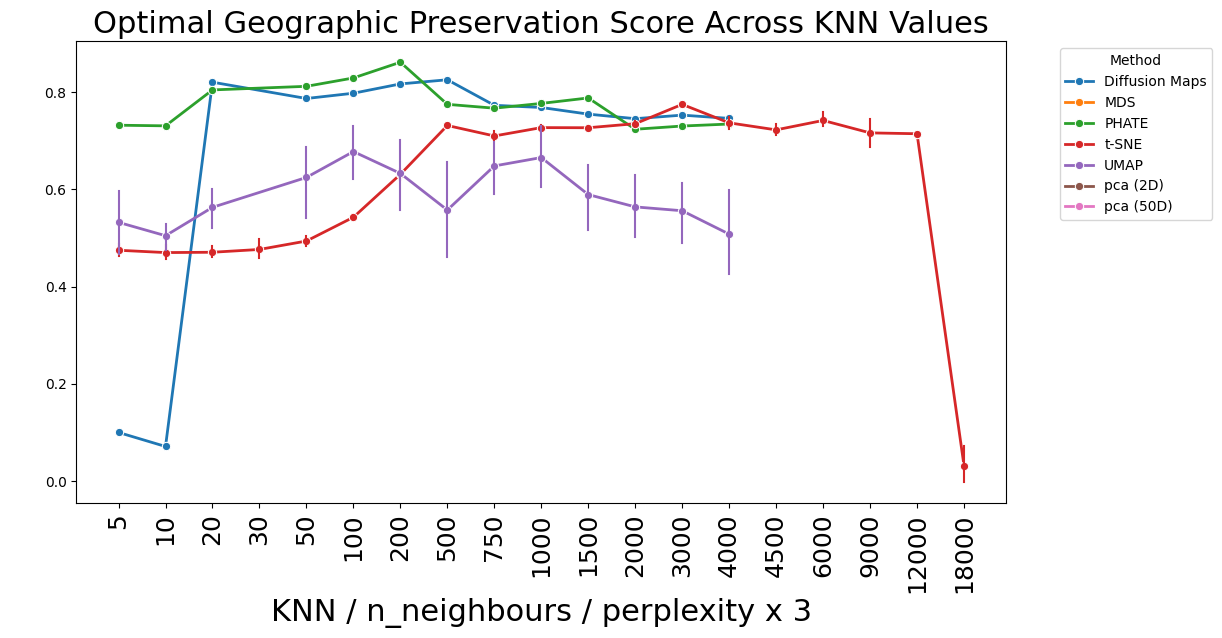

In [8]:
plot_metric_vs_K('geographic_preservation', 'Geographic Preservation', df)

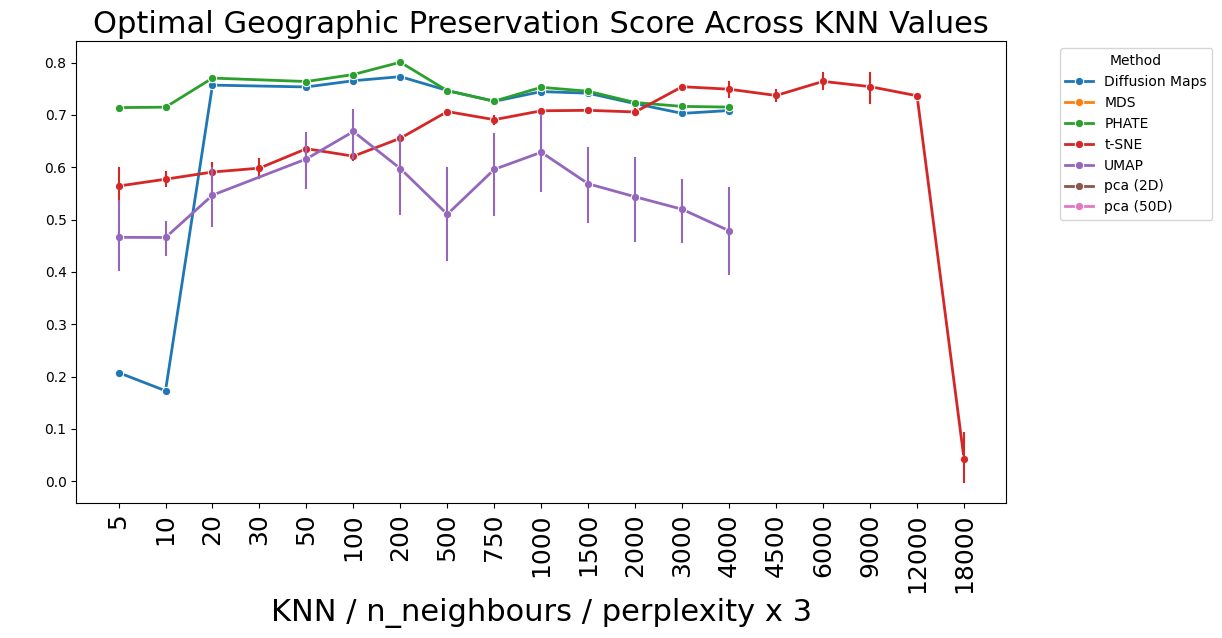

In [9]:
plot_metric_vs_K('geographic_preservation_medians', 'Geographic Preservation', df) 

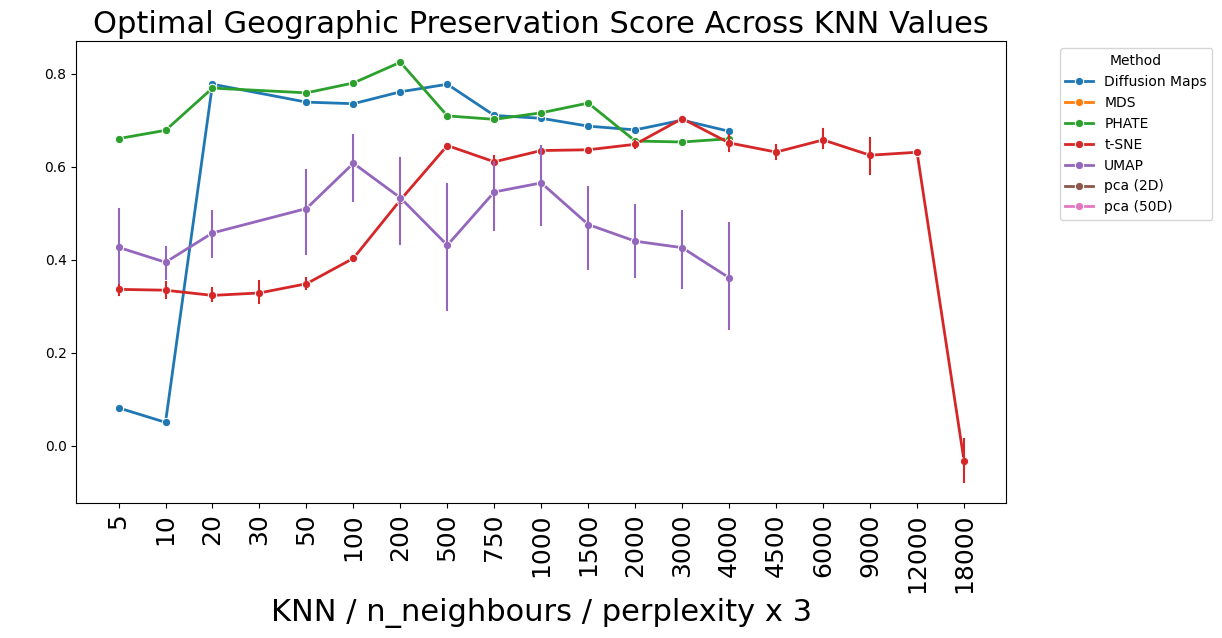

In [10]:
plot_metric_vs_K('geographic_preservation_far', 'Geographic Preservation', df) 

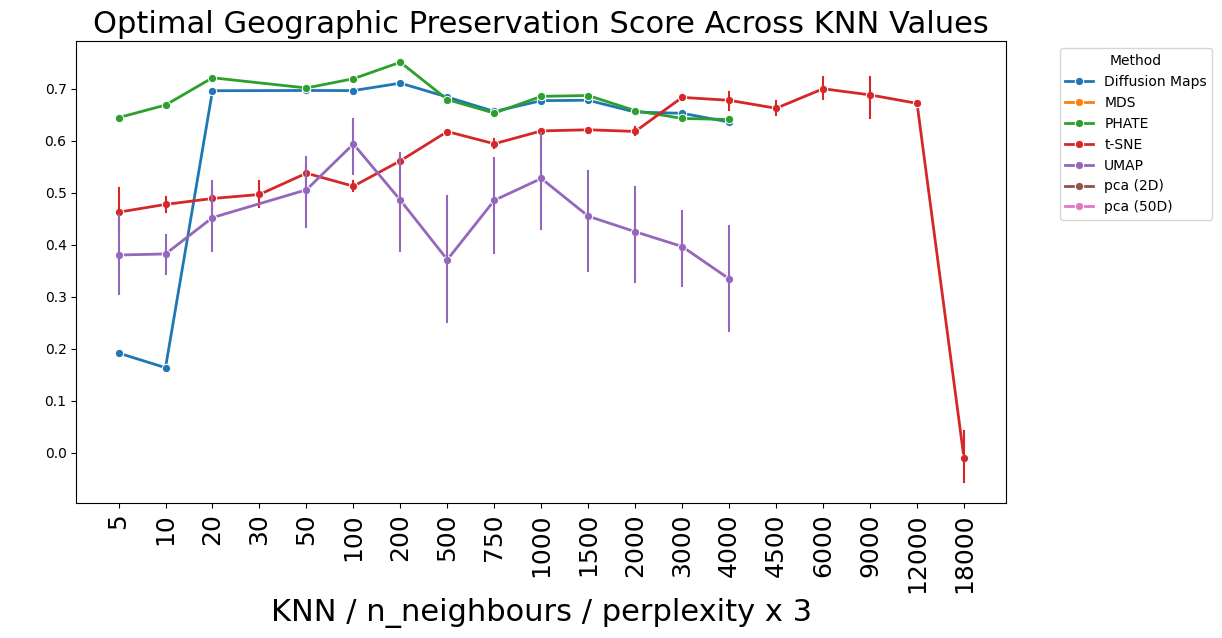

In [11]:
plot_metric_vs_K('geographic_preservation_medians_far', 'Geographic Preservation', df) 

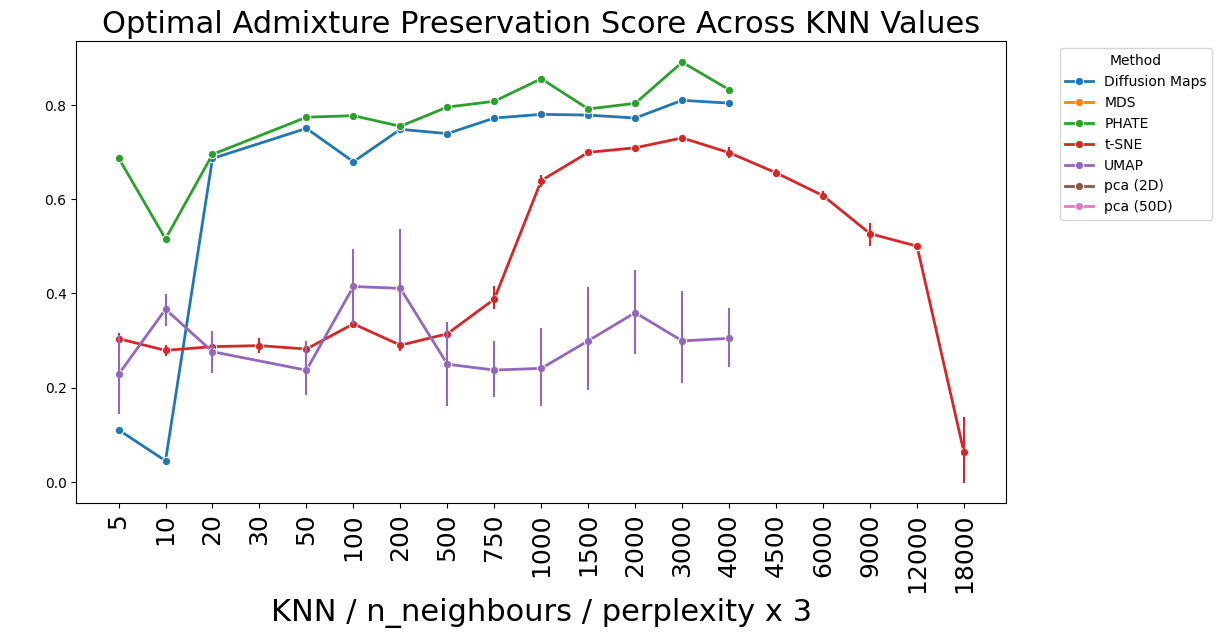

In [12]:
plot_metric_vs_K('admixture_preservation', 'Admixture Preservation', df)

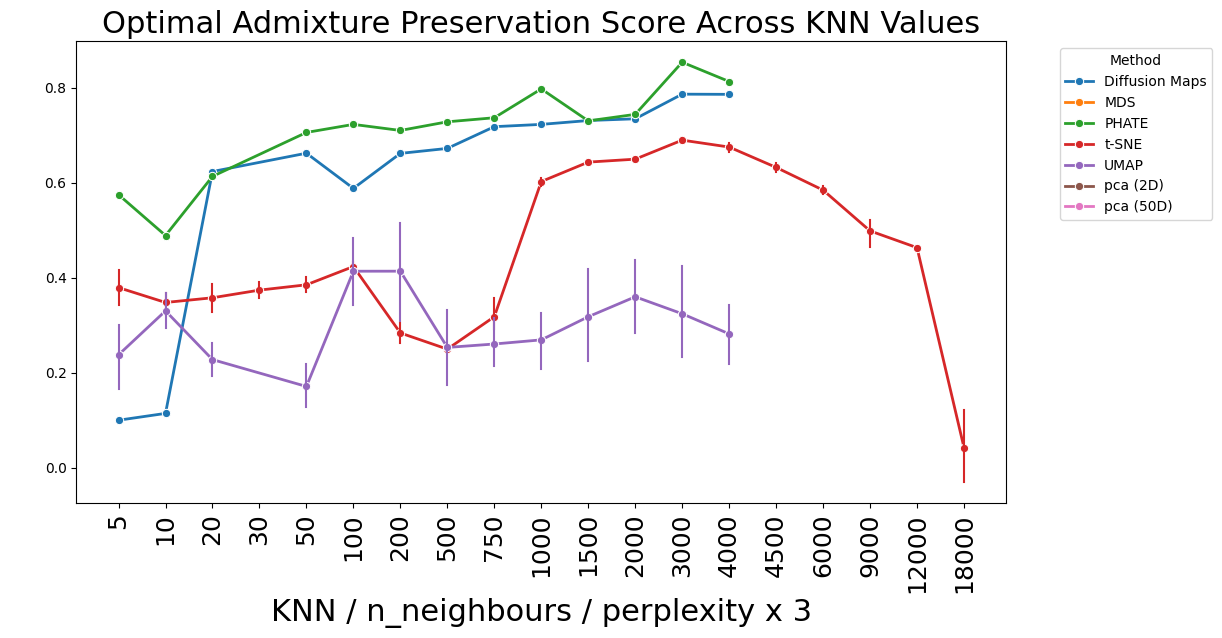

In [13]:
plot_metric_vs_K('admixture_preservation_medians', 'Admixture Preservation', df)

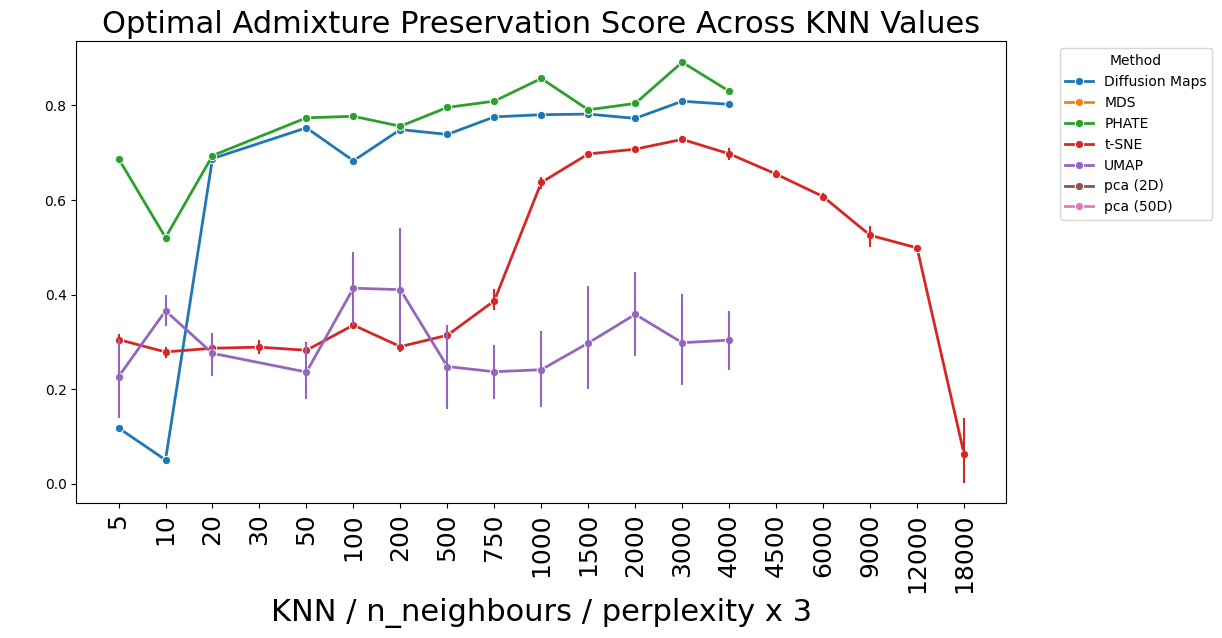

In [14]:
plot_metric_vs_K('admixture_preservation_far', 'Admixture Preservation', df)

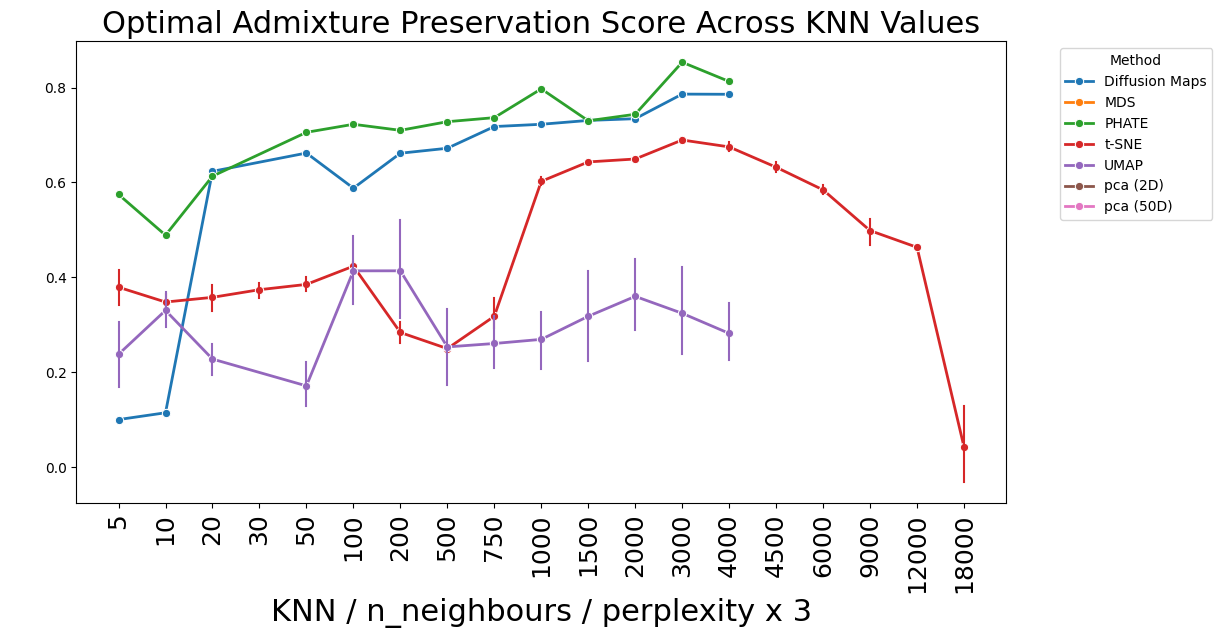

In [15]:
plot_metric_vs_K('admixture_preservation_medians_far', 'Admixture Preservation', df)

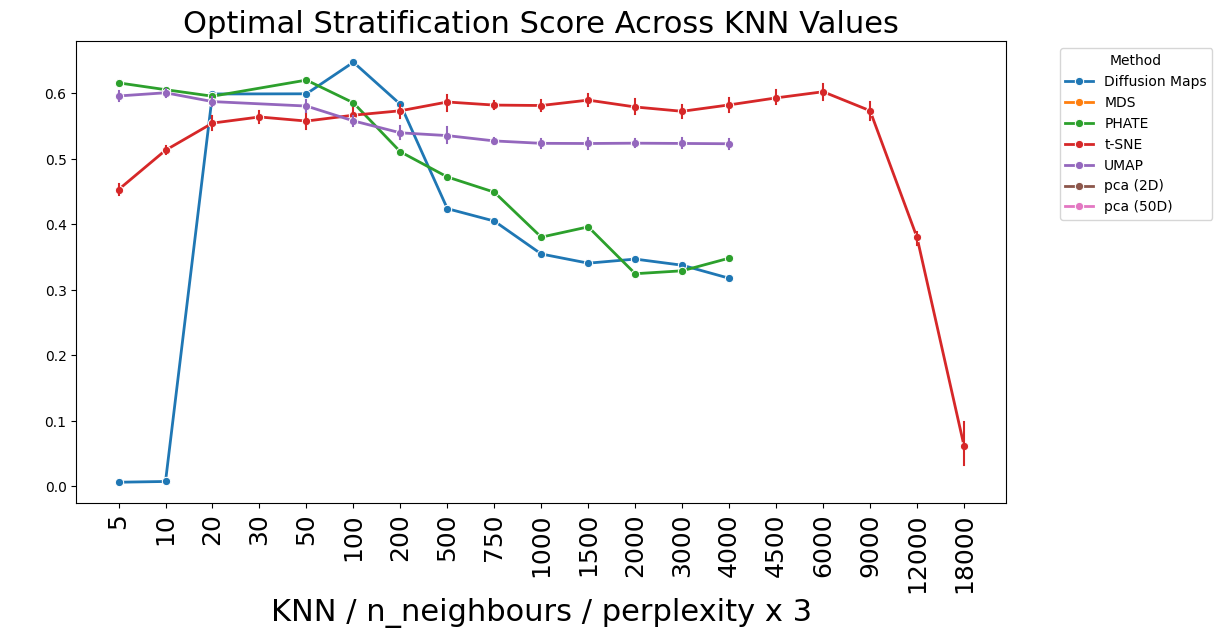

In [16]:
# stratification performance
plot_metric_vs_K('stratification', 'Stratification', df)

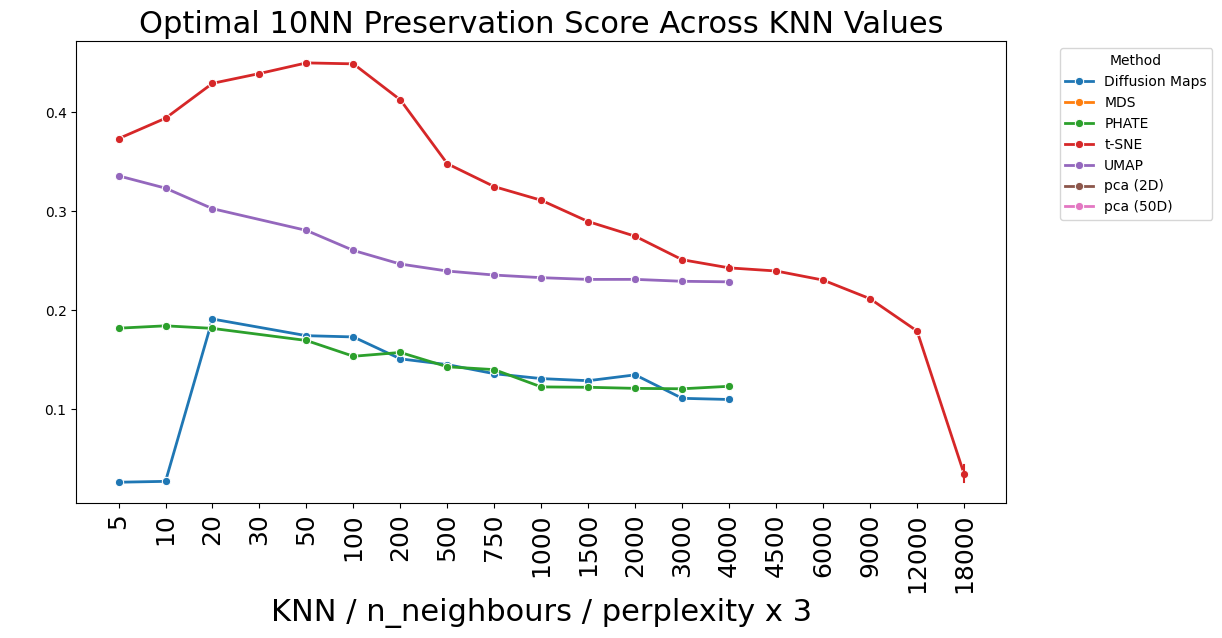

In [17]:
plot_metric_vs_K('knn_preservation', '10NN Preservation', df)

In [ ]:
def compare_side_by_side(variable1, metric_name1, variable2, metric_name2, df):
    """
    Compare default vs optimized parameters for different dimensionality reduction methods.
    
    Parameters:
    variable1 (str): Column name for the first metric (e.g., "geographic_preservation").
    metric_name1 (str): Display name for the first metric.
    variable2 (str): Column name for the second metric (e.g., "admixture_preservation_far").
    metric_name2 (str): Display name for the second metric.
    df (pd.DataFrame): DataFrame containing the results.
    """
    
    # Define default parameters for each method
    default_params = {
        "t-SNE": {"perplexity": 33},
        "UMAP": {"n_neighbors": 20},
        "PHATE": {"knn": 5, "decay": 40},
        "Diffusion Maps": {"knn": 5, "decay": 40}
    }

    # Define optimized large K parameters for each method
    optimized_params = {
        "t-SNE": {"perplexity": 2000},
        "UMAP": {"n_neighbors": 4000},
        "PHATE": {"knn": 200},
        "Diffusion Maps" : {"knn": 200}
    }

    def extract_best_rows(params, metric):
        """Extracts the best-performing row for each method.
           For UMAP, extracts the best row per seed."""
        best_rows = []
        for method, param_values in params.items():
            query = (df["method"] == method)
            for param, value in param_values.items():
                query &= df[param] == value
            filtered_df = df[query]

            if not filtered_df.empty:
                if method in ["UMAP", "t-SNE", "MDS"]:
                    # Get the best result per unique seed
                    for seed in filtered_df["seed"].unique():
                        seed_df = filtered_df[filtered_df["seed"] == seed]
                        best_idx = seed_df[metric].idxmax()
                        best_rows.append(df.loc[best_idx])
                else:
                    best_idx = filtered_df[metric].idxmax()
                    best_rows.append(df.loc[best_idx])

        return pd.DataFrame(best_rows)

    # Extract the best-performing rows for each metric
    default_admix = extract_best_rows(default_params, variable2)[['method', variable2]]
    default_admix["method"] += " (default)"

    optimized_admix = extract_best_rows(optimized_params, variable2)[['method', variable2]]
    optimized_admix["method"] += " (optimized)"

    default_geo = extract_best_rows(default_params, variable1)[['method', variable1]]
    default_geo["method"] += " (default)"

    optimized_geo = extract_best_rows(optimized_params, variable1)[['method', variable1]]
    optimized_geo["method"] += " (optimized)"

    # Create comparison dataframe
    mds_results = df.query("method == 'MDS'")[["method", variable1, variable2]]
    pca_results = df.query("method == 'PCA'")[["method", variable1, variable2]]

    comparison_df = pd.concat([
        pca_results,
        mds_results,
        optimized_geo.merge(optimized_admix, on='method'),
        default_geo.merge(default_admix, on='method')
    ])

    # Define the desired order
    method_order = [
        "pca (50D)", "pca (2D)", 
        "MDS", "t-SNE (default)", "UMAP (default)", "Diffusion Maps (default)", "PHATE (default)",
        "t-SNE (optimized)", "UMAP (optimized)", "Diffusion Maps (optimized)", "PHATE (optimized)"
    ]

    # Convert 'method' to a categorical type to enforce the order
    comparison_df["method"] = pd.Categorical(comparison_df["method"], categories=method_order, ordered=True)
    
    # Sort the dataframe based on the specified order
    comparison_df = comparison_df.sort_values("method").reset_index(drop=True)

    # Melt the data for seaborn
    plot_data = comparison_df.melt(id_vars=["method"], 
                                   value_vars=[variable1, variable2],
                                   var_name="Metric", 
                                   value_name="Score")

    plot_data['Metric'] = plot_data['Metric'].map({variable1: metric_name1, variable2: metric_name2})

    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_data, 
        x="method", 
        y="Score", 
        hue="Metric",  
        palette=["gray", "lightgray"]
    )

    # Set y-axis limit
    plt.ylim(0.3, plot_data["Score"].max() + 0.05)

    # Labels and title
    plt.xticks(rotation=90, size=18)
    plt.xlabel("Method", size=22)
    plt.ylabel("Score", size=22)
    plt.title("{} & {} (Default vs. Optimized)".format(metric_name1, metric_name2), size=22)
    plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.show()

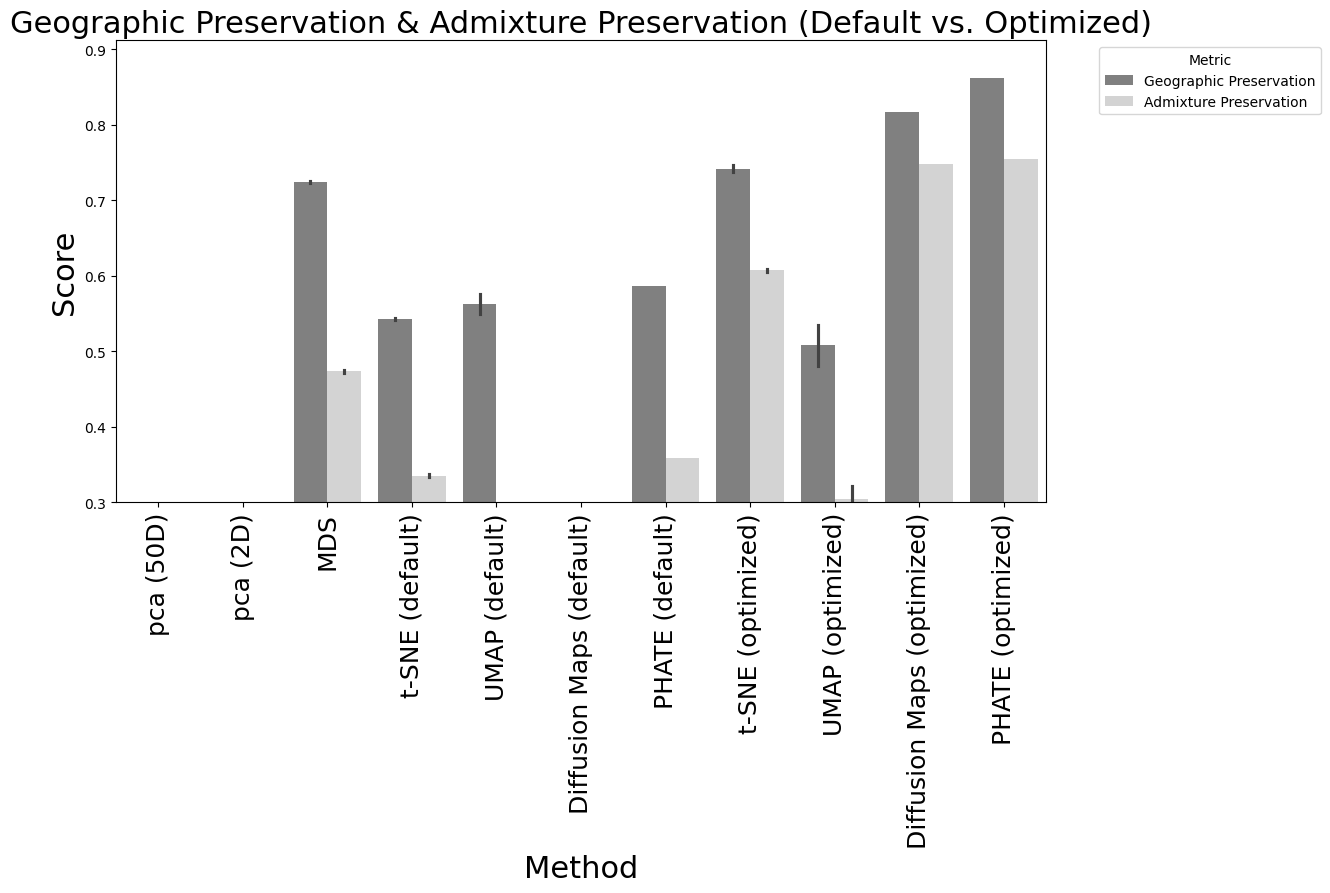

In [19]:
compare_side_by_side('geographic_preservation', 'Geographic Preservation', 
                     "admixture_preservation", "Admixture Preservation", df)

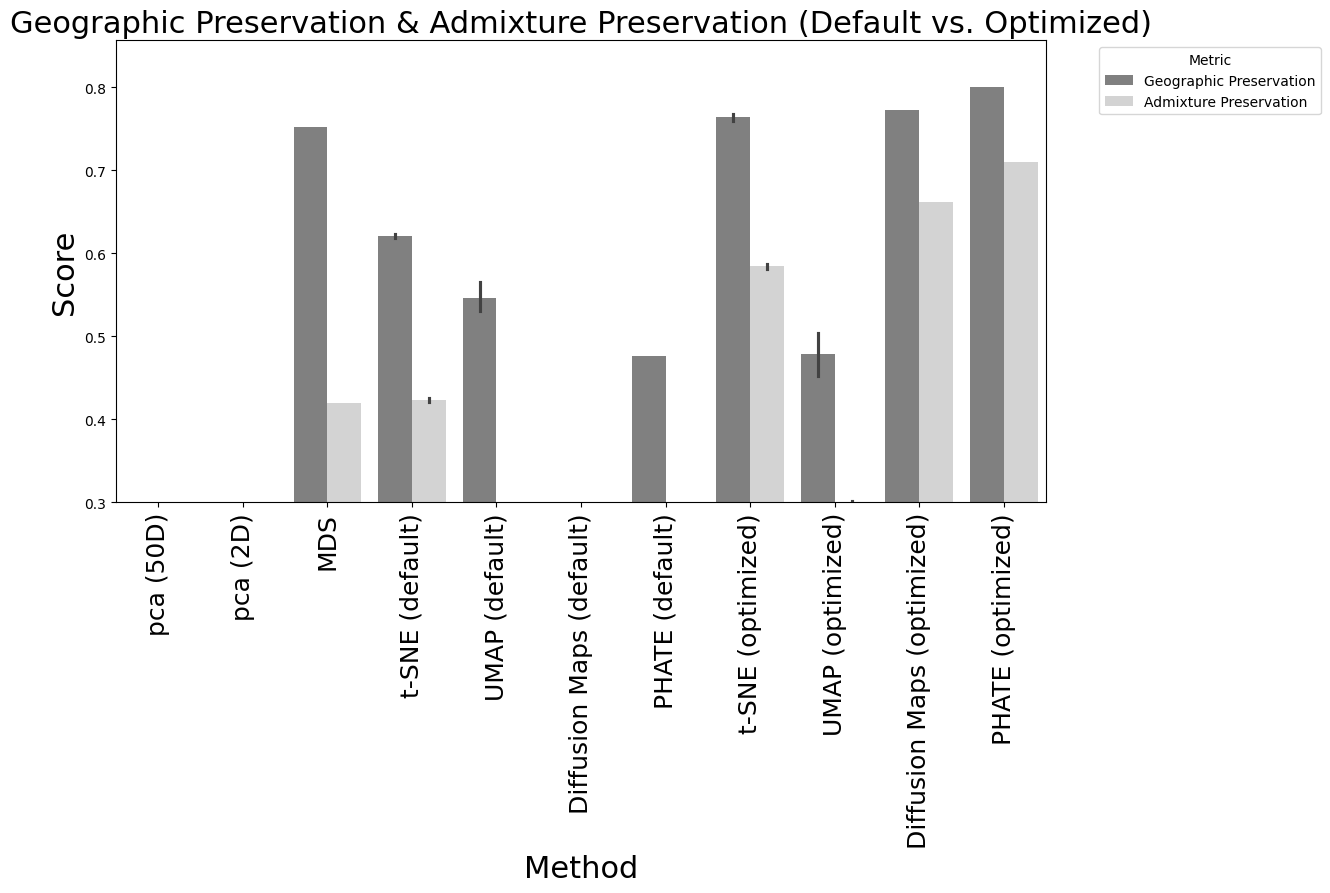

In [20]:
compare_side_by_side('geographic_preservation_medians', 'Geographic Preservation', 
                     "admixture_preservation_medians", "Admixture Preservation", df)

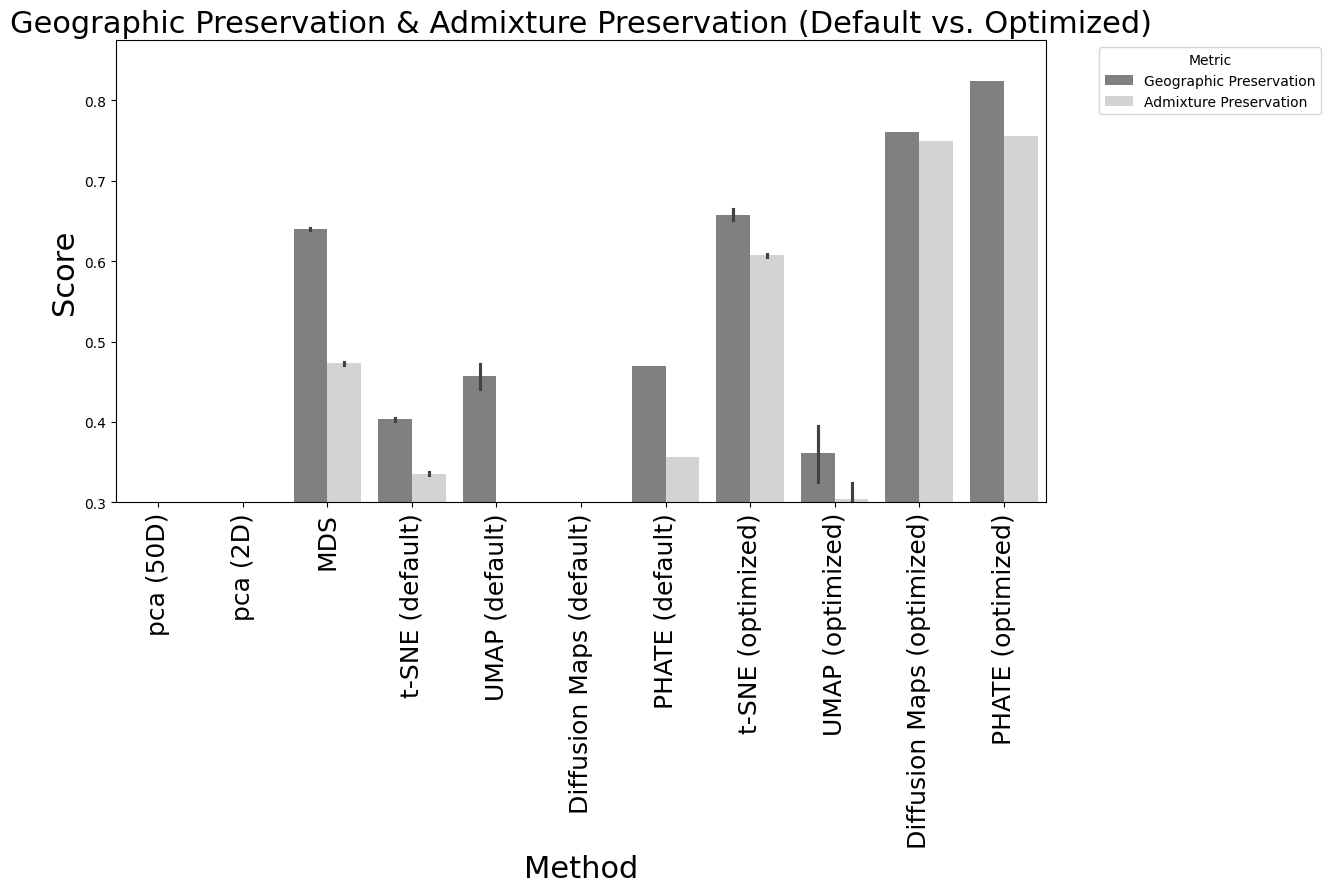

In [21]:
compare_side_by_side('geographic_preservation_far', 'Geographic Preservation', 
                     "admixture_preservation_far", "Admixture Preservation", df)

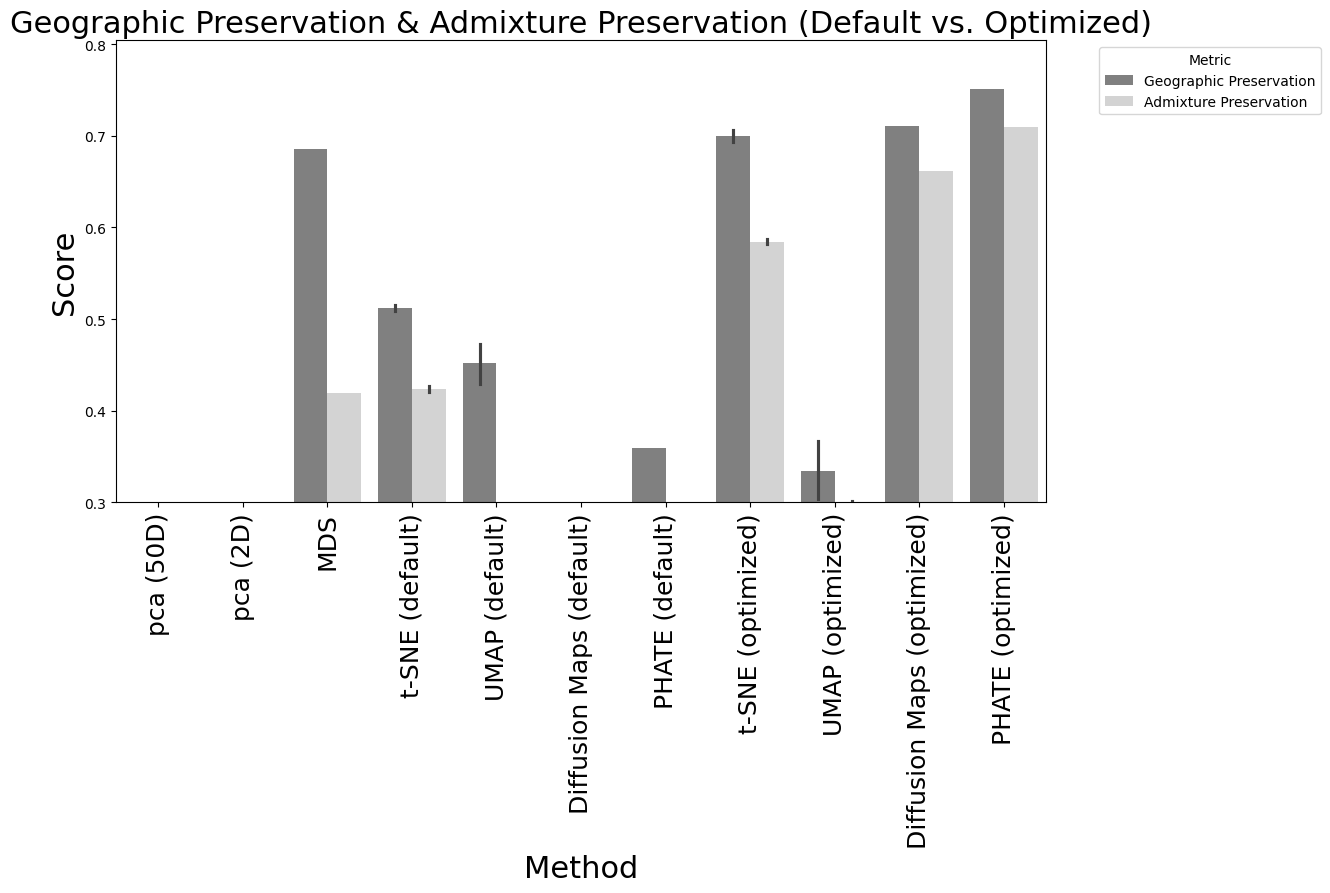

In [22]:
compare_side_by_side('geographic_preservation_medians_far', 'Geographic Preservation', 
                     "admixture_preservation_medians_far", "Admixture Preservation", df)

## Compare Local/Global Tradeoff

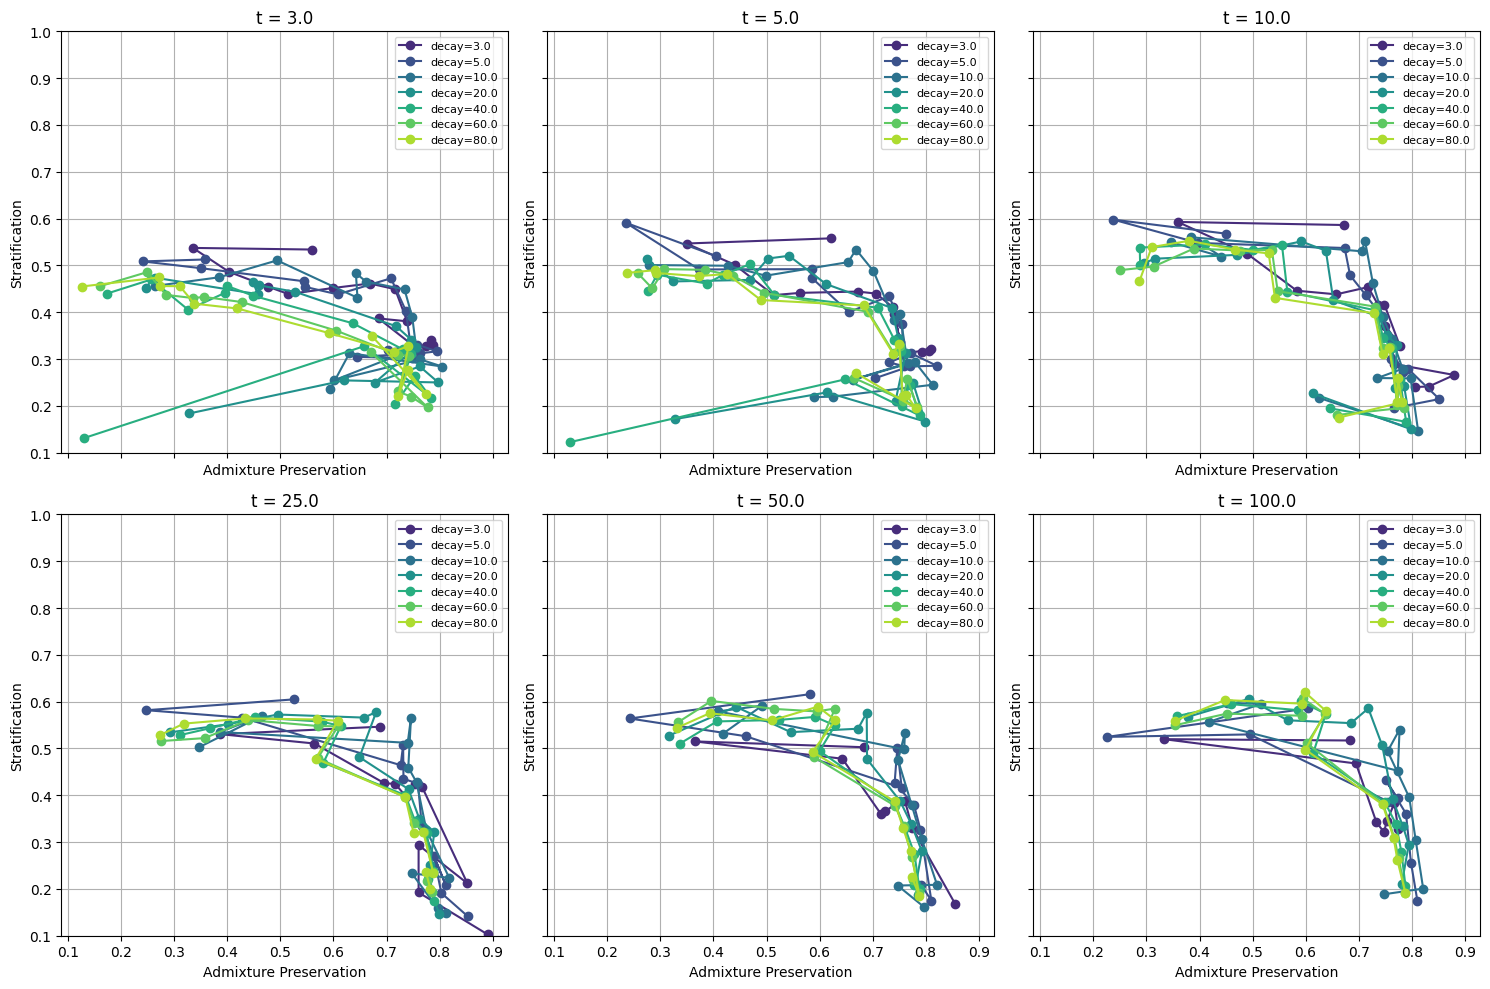

In [60]:
phate_df = df.query("method == 'PHATE' and stratification >= 0.1")
t_vals = sorted(phate_df['t'].unique())
ncols = 3
nrows = -(-len(t_vals) // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

decay_palette = sns.color_palette("viridis", n_colors=phate_df['decay'].nunique())
decay_vals = sorted(phate_df['decay'].unique())
decay_color_map = {d: c for d, c in zip(decay_vals, decay_palette)}

for i, t_val in enumerate(t_vals):
    ax = axes[i]
    for decay_val in decay_vals:
        subset = phate_df.query("t == @t_val and decay == @decay_val")
        grouped = (
            subset
            .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
            .max()
            .sort_index()
        )
        if grouped.empty:
            continue
        ax.plot(
            grouped['admixture_preservation'],
            grouped['stratification'],
            marker='o',
            color=decay_color_map[decay_val],
            label=f"decay={decay_val}"
        )
    ax.set_title(f"t = {t_val}")
    ax.set_xlabel("Admixture Preservation")
    ax.set_ylabel("Stratification")
    ax.set_ylim(0.1, 1)
    ax.grid(True)
    ax.legend(fontsize=8)

# Hide unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

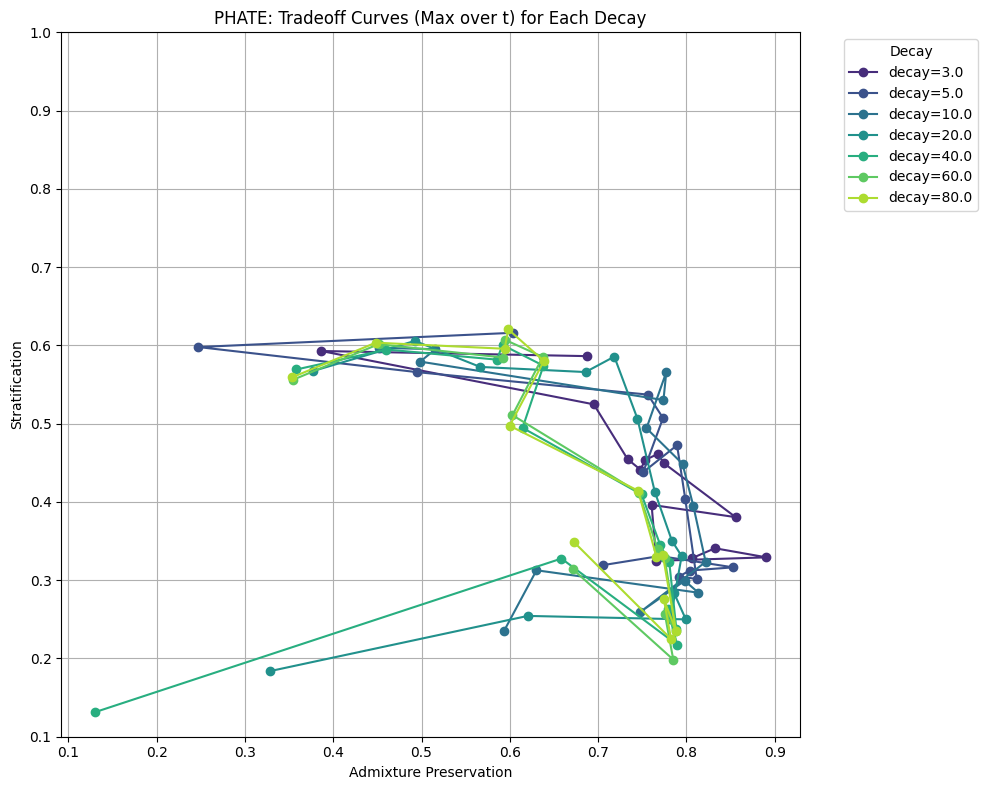

In [61]:
# Filter to PHATE only and remove low-stratification noise
phate_df = df.query("method == 'PHATE' and stratification >= 0.1")

# Define color palette for decay values
decay_vals = sorted(phate_df['decay'].unique())
palette = sns.color_palette("viridis", n_colors=len(decay_vals))
decay_color_map = {d: c for d, c in zip(decay_vals, palette)}

# Create figure
plt.figure(figsize=(10, 8))

# Loop over each decay value
for decay_val in decay_vals:
    # Filter to just that decay
    subset = phate_df.query("decay == @decay_val")

    # Group by KNN (or perplexity etc.), and max over t
    grouped = (
        subset
        .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
        .max()  # max over t
        .sort_index()
    )

    if grouped.empty:
        continue

    # Plot the curve
    plt.plot(
        grouped['admixture_preservation'],
        grouped['stratification'],
        marker='o',
        label=f"decay={decay_val}",
        color=decay_color_map[decay_val]
    )

# Labeling and aesthetics
plt.xlabel("Admixture Preservation")
plt.ylabel("Stratification")
plt.title("PHATE: Tradeoff Curves (Max over t) for Each Decay")
plt.ylim(0.1, 1)
plt.grid(True)
plt.legend(title="Decay", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [62]:
def compute_pareto_frontier(df, xcol, ycol, maximize=True):
    """
    Given a DataFrame with xcol and ycol, return only the Pareto-optimal rows.

    Assumes both axes are to be maximized (or minimized if maximize=False).
    """
    data = df[[xcol, ycol]].dropna().copy()
    if not maximize:
        data[xcol] = -data[xcol]
        data[ycol] = -data[ycol]

    # Sort by x descending
    data = data.sort_values(by=xcol, ascending=False)

    pareto = []
    current_best_y = -np.inf
    for _, row in data.iterrows():
        if row[ycol] > current_best_y:
            pareto.append(row)
            current_best_y = row[ycol]

    pareto_df = pd.DataFrame(pareto)
    if not maximize:
        pareto_df[xcol] = -pareto_df[xcol]
        pareto_df[ycol] = -pareto_df[ycol]

    return pareto_df

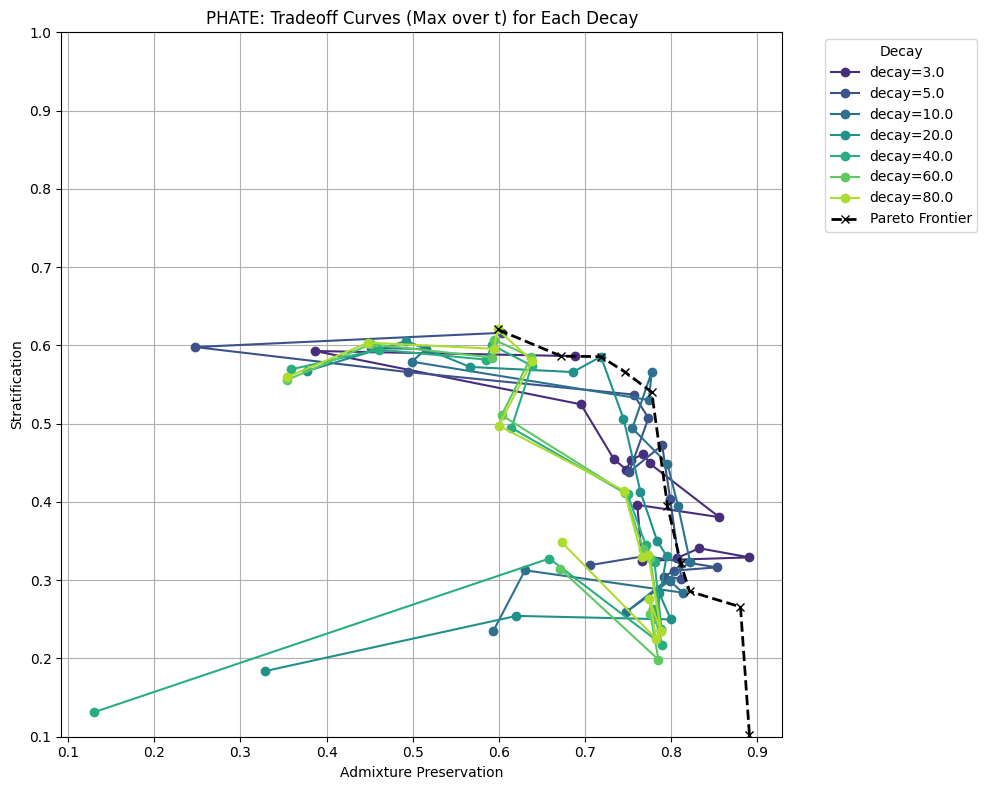

In [63]:
# Filter to PHATE only and remove low-stratification noise
phate_df = df.query("method == 'PHATE' and stratification >= 0.1")

# Define color palette for decay values
decay_vals = sorted(phate_df['decay'].unique())
palette = sns.color_palette("viridis", n_colors=len(decay_vals))
decay_color_map = {d: c for d, c in zip(decay_vals, palette)}

# Create figure
plt.figure(figsize=(10, 8))

# Loop over each decay value
for decay_val in decay_vals:
    # Filter to just that decay
    subset = phate_df.query("decay == @decay_val")

    # Group by KNN (or perplexity etc.), and max over t
    grouped = (
        subset
        .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
        .max()  # max over t
        .sort_index()
    )

    if grouped.empty:
        continue

    # Plot the curve
    plt.plot(
        grouped['admixture_preservation'],
        grouped['stratification'],
        marker='o',
        label=f"decay={decay_val}",
        color=decay_color_map[decay_val]
    )

# --- Add Pareto frontier across all points ---
all_points = phate_df[['admixture_preservation', 'stratification']].dropna()

pareto_df = compute_pareto_frontier(all_points, 'admixture_preservation', 'stratification')

# Plot Pareto curve
plt.plot(
    pareto_df['admixture_preservation'],
    pareto_df['stratification'],
    color='black',
    linestyle='--',
    linewidth=2,
    marker='x',
    label='Pareto Frontier'
)

# Labeling and aesthetics
plt.xlabel("Admixture Preservation")
plt.ylabel("Stratification")
plt.title("PHATE: Tradeoff Curves (Max over t) for Each Decay")
plt.ylim(0.1, 1)
plt.grid(True)
plt.legend(title="Decay", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

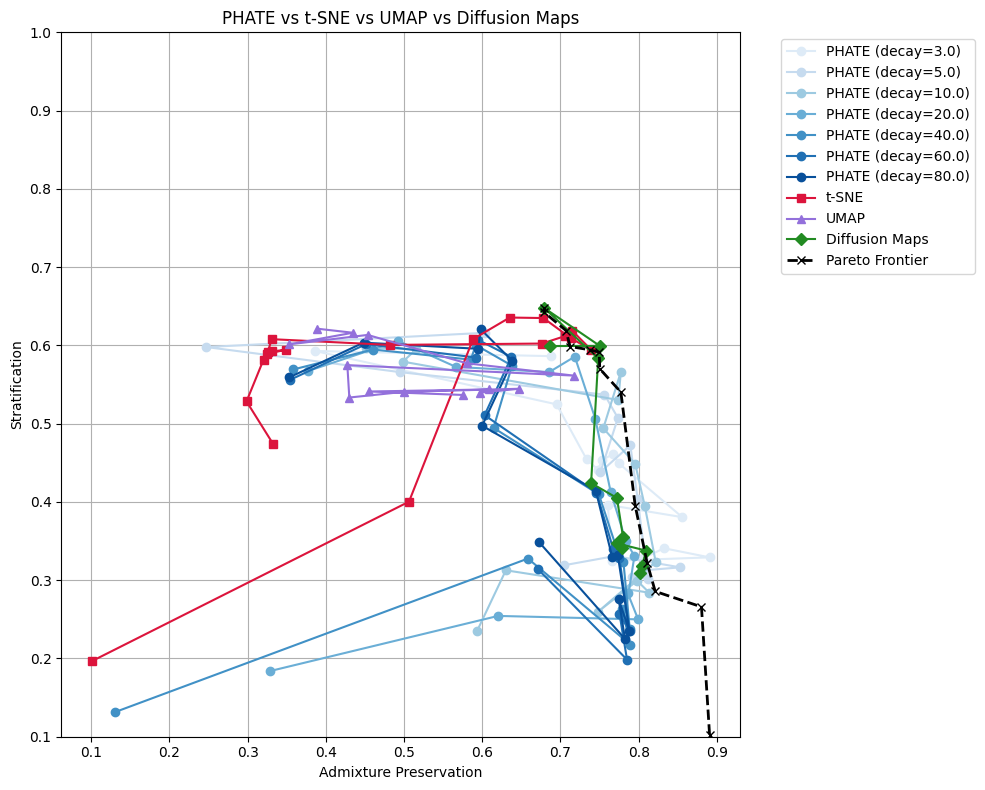

In [64]:
# Assume df already exists

def compute_pareto_frontier(df, xcol, ycol, maximize=True):
    data = df[[xcol, ycol]].dropna().copy()
    if not maximize:
        data[xcol] = -data[xcol]
        data[ycol] = -data[ycol]
    data = data.sort_values(by=xcol, ascending=False)
    pareto = []
    current_best_y = -np.inf
    for _, row in data.iterrows():
        if row[ycol] > current_best_y:
            pareto.append(row)
            current_best_y = row[ycol]
    pareto_df = pd.DataFrame(pareto)
    if not maximize:
        pareto_df[xcol] = -pareto_df[xcol]
        pareto_df[ycol] = -pareto_df[ycol]
    return pareto_df

# --- Start plotting ---
plt.figure(figsize=(10, 8))

# Base settings
plt.xlabel("Admixture Preservation")
plt.ylabel("Stratification")
plt.title("PHATE vs t-SNE vs UMAP vs Diffusion Maps")
plt.ylim(0.1, 1)
plt.grid(True)

# --- PHATE (multiple decay curves) ---
phate_df = df.query("method == 'PHATE' and stratification >= 0.1")
decay_vals = sorted(phate_df['decay'].unique())
palette = sns.color_palette("Blues", n_colors=len(decay_vals))
decay_color_map = {d: c for d, c in zip(decay_vals, palette)}

for decay_val in decay_vals:
    subset = phate_df.query("decay == @decay_val")
    grouped = (
        subset
        .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
        .max()  # max over t
        .sort_index()
    )
    if grouped.empty:
        continue
    plt.plot(
        grouped['admixture_preservation'],
        grouped['stratification'],
        marker='o',
        color=decay_color_map[decay_val],
        label=f"PHATE (decay={decay_val})"
    )

# --- t-SNE ---
tsne_df = df.query("method == 't-SNE' and stratification >= 0.1")
tsne_grouped = (
    tsne_df
    .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
    .max()
    .sort_index()
)
plt.plot(
    tsne_grouped['admixture_preservation'],
    tsne_grouped['stratification'],
    color='crimson',
    marker='s',
    linestyle='-',
    label='t-SNE'
)

# --- UMAP ---
umap_df = df.query("method == 'UMAP' and stratification >= 0.1")
umap_grouped = (
    umap_df
    .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
    .max()
    .sort_index()
)
plt.plot(
    umap_grouped['admixture_preservation'],
    umap_grouped['stratification'],
    color='mediumpurple',
    marker='^',
    linestyle='-',
    label='UMAP'
)

# --- Diffusion Maps ---
diff_df = df.query("method == 'Diffusion Maps' and stratification >= 0.1")
diff_grouped = (
    diff_df
    .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
    .max()
    .sort_index()
)
plt.plot(
    diff_grouped['admixture_preservation'],
    diff_grouped['stratification'],
    color='forestgreen',
    marker='D',
    linestyle='-',
    label='Diffusion Maps'
)

# --- Pareto frontier from all points ---
all_points = df.query("stratification >= 0.1")[['admixture_preservation', 'stratification']]
pareto_df = compute_pareto_frontier(all_points, 'admixture_preservation', 'stratification')

plt.plot(
    pareto_df['admixture_preservation'],
    pareto_df['stratification'],
    color='black',
    linestyle='--',
    linewidth=2,
    marker='x',
    label='Pareto Frontier'
)

# Legend + layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

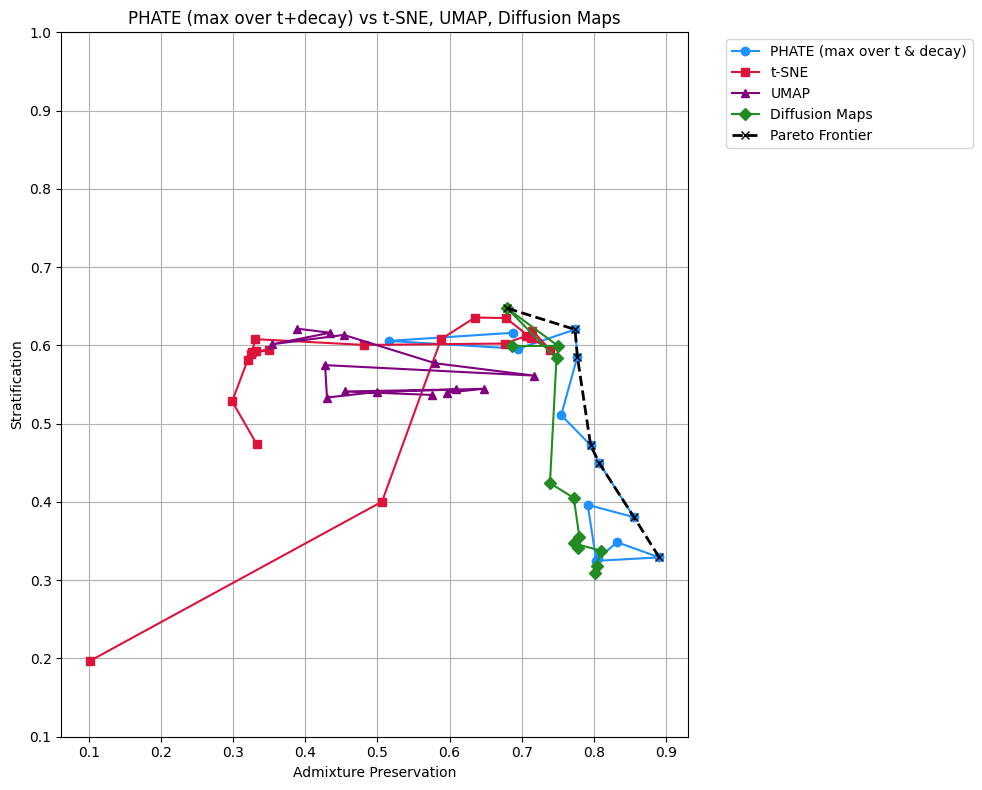

In [65]:
# Compute max curves per method
def get_max_curve(df, method):
    return (
        df.query("method == @method and stratification >= 0.1")
          .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
          .max()
          .sort_index()
    )

# Get curves
phate_curve = get_max_curve(df, "PHATE")
tsne_curve = get_max_curve(df, "t-SNE")
umap_curve = get_max_curve(df, "UMAP")
diff_curve = get_max_curve(df, "Diffusion Maps")

# Plot setup
plt.figure(figsize=(10, 8))
plt.xlabel("Admixture Preservation")
plt.ylabel("Stratification")
plt.title("PHATE (max over t+decay) vs t-SNE, UMAP, Diffusion Maps")
plt.ylim(0.1, 1)
plt.grid(True)

# Plot each curve
plt.plot(phate_curve['admixture_preservation'], phate_curve['stratification'],
         label="PHATE (max over t & decay)", color='dodgerblue', marker='o')

plt.plot(tsne_curve['admixture_preservation'], tsne_curve['stratification'],
         label="t-SNE", color='crimson', marker='s')

plt.plot(umap_curve['admixture_preservation'], umap_curve['stratification'],
         label="UMAP", color='purple', marker='^')

plt.plot(diff_curve['admixture_preservation'], diff_curve['stratification'],
         label="Diffusion Maps", color='forestgreen', marker='D')

# Pareto frontier across all methods
all_points = pd.concat([
    phate_curve,
    tsne_curve,
    umap_curve,
    diff_curve
]).dropna()

def compute_pareto_frontier(df, xcol, ycol):
    data = df[[xcol, ycol]].dropna().sort_values(by=xcol, ascending=False)
    pareto = []
    best_y = -np.inf
    for _, row in data.iterrows():
        if row[ycol] > best_y:
            pareto.append(row)
            best_y = row[ycol]
    return pd.DataFrame(pareto)

pareto_df = compute_pareto_frontier(all_points, 'admixture_preservation', 'stratification')

plt.plot(pareto_df['admixture_preservation'], pareto_df['stratification'],
         label="Pareto Frontier", color='black', linestyle='--', linewidth=2, marker='x')

# Final touches
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

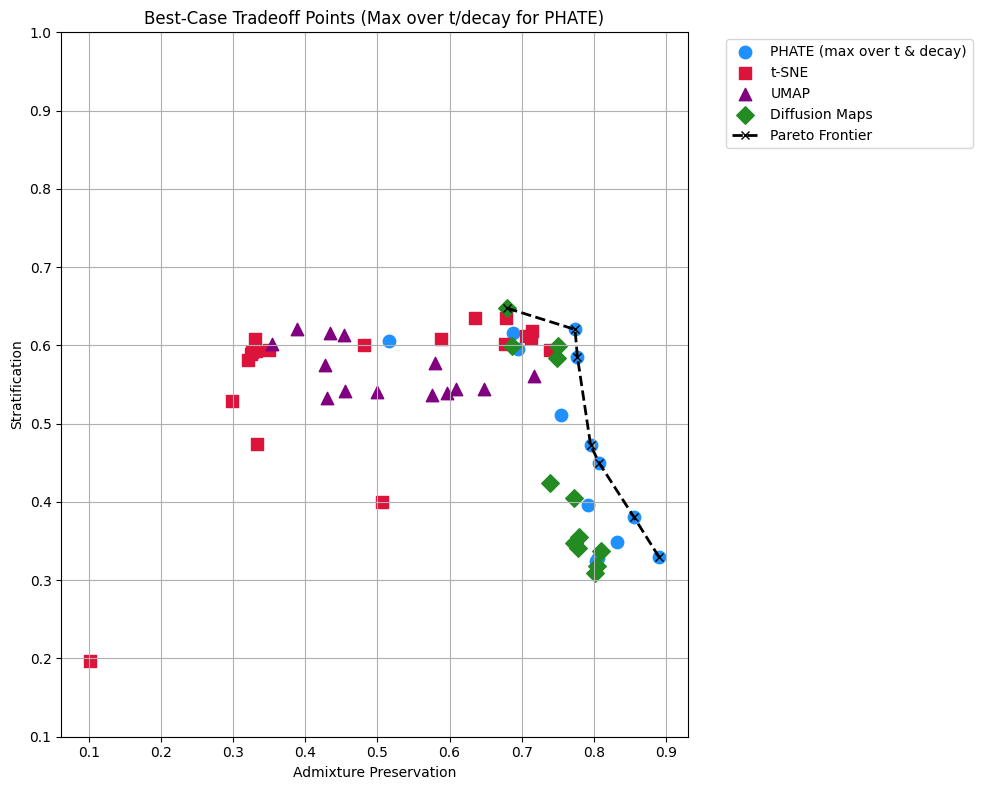

In [66]:
# Function to compute max curve per method
def get_max_curve(df, method):
    return (
        df.query("method == @method and stratification >= 0.1")
          .groupby("KNN / n_neighbours / perplexity x 3")[['admixture_preservation', 'stratification']]
          .max()
          .sort_index()
    )

# Load all points
phate_curve = get_max_curve(df, "PHATE")
tsne_curve = get_max_curve(df, "t-SNE")
umap_curve = get_max_curve(df, "UMAP")
diff_curve = get_max_curve(df, "Diffusion Maps")

# Plot setup
plt.figure(figsize=(10, 8))
plt.xlabel("Admixture Preservation")
plt.ylabel("Stratification")
plt.title("Best-Case Tradeoff Points (Max over t/decay for PHATE)")
plt.ylim(0.1, 1)
plt.grid(True)

# Plot as scatter points only (no lines)
plt.scatter(phate_curve['admixture_preservation'], phate_curve['stratification'],
            label="PHATE (max over t & decay)", color='dodgerblue', marker='o', s=80)

plt.scatter(tsne_curve['admixture_preservation'], tsne_curve['stratification'],
            label="t-SNE", color='crimson', marker='s', s=80)

plt.scatter(umap_curve['admixture_preservation'], umap_curve['stratification'],
            label="UMAP", color='purple', marker='^', s=80)

plt.scatter(diff_curve['admixture_preservation'], diff_curve['stratification'],
            label="Diffusion Maps", color='forestgreen', marker='D', s=80)

# --- Pareto frontier ---
all_points = pd.concat([
    phate_curve,
    tsne_curve,
    umap_curve,
    diff_curve
]).dropna()

def compute_pareto_frontier(df, xcol, ycol):
    data = df[[xcol, ycol]].dropna().sort_values(by=xcol, ascending=False)
    pareto = []
    best_y = -np.inf
    for _, row in data.iterrows():
        if row[ycol] > best_y:
            pareto.append(row)
            best_y = row[ycol]
    return pd.DataFrame(pareto)

pareto_df = compute_pareto_frontier(all_points, 'admixture_preservation', 'stratification')

plt.plot(pareto_df['admixture_preservation'], pareto_df['stratification'],
         label="Pareto Frontier", color='black', linestyle='--', linewidth=2, marker='x')

# Finalize
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()